# RSNA 2024 Lumbar Spine Degenerative Classification

## Starter Notebook for Pytorch and Deep learning techniques

Using ResNET

What does this notebook contains?

* Data organized in an understandable and easy to use way
* A pretrained ResNET for inference

I have tried creating a notebook where you can just plug your deep learning models and everything else is sorted. 

In [10]:
import seaborn as sns

import matplotlib.pyplot as plt
import os
import time
import numpy as np
import glob
import json
import collections
import torch
import torch.nn as nn

import pydicom as dicom
import matplotlib.patches as patches

from matplotlib import animation, rc
import pandas as pd

import pydicom as dicom # dicom
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

In [11]:
# read data
train_path = train_path = '.\\data_chaimae\\'

train  = pd.read_csv(train_path + 'train.csv')

label = pd.read_csv(train_path + 'train_label_coordinates.csv')
train_desc  = pd.read_csv(train_path + 'train_series_descriptions.csv')
train_desc['series_description'] = train_desc['series_description'].replace('Sagittal T2/STIR', 'Sagittal T2')
test_desc   = pd.read_csv(train_path + 'test_series_descriptions.csv')
test_desc['series_description'] = test_desc['series_description'].replace('Sagittal T2/STIR', 'Sagittal T2')
sub         = pd.read_csv(train_path + 'sample_submission.csv')

In [12]:
label.head()

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602


In [13]:
test_desc.head(5)

,study_id,series_id,series_description
0,44036939,2828203845,Sagittal T1
1,44036939,3481971518,Axial T2
2,44036939,3844393089,Sagittal T2


In [14]:
train.head(5)

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


In [15]:
train_desc.head(5)

,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1


In [16]:
# Function to generate image paths based on directory structure
def generate_image_paths(df, data_dir):
    image_paths = []
    for study_id, series_id in zip(df['study_id'], df['series_id']):
        study_dir = os.path.join(data_dir, str(study_id))
        series_dir = os.path.join(study_dir, str(series_id))
        images = os.listdir(series_dir)
        image_paths.extend([os.path.join(series_dir, img) for img in images])
    return image_paths

# Generate image paths for train and test data
train_image_paths = generate_image_paths(train_desc, f'{train_path}train_images')
test_image_paths = generate_image_paths(test_desc, f'{train_path}test_images')

In [17]:
len(train_desc)

6294

In [18]:
len(train_image_paths)

147218

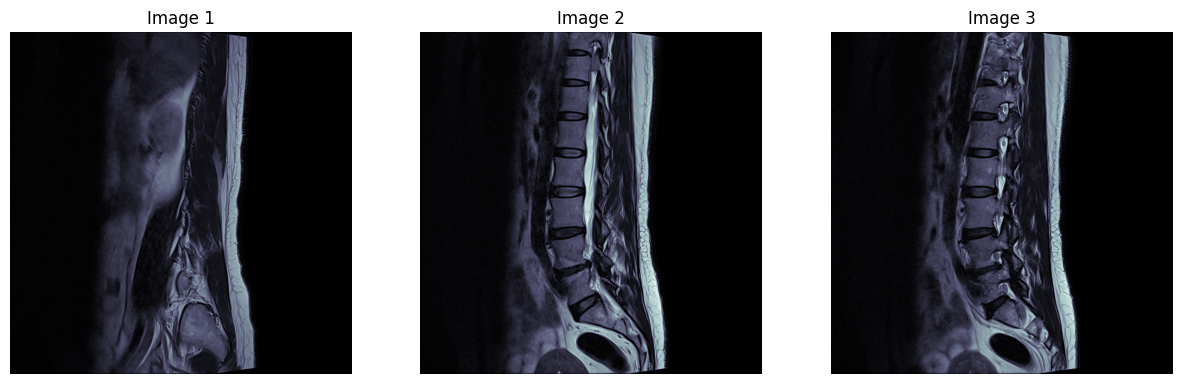

In [19]:
import pydicom
import matplotlib.pyplot as plt

# Function to open and display DICOM images
def display_dicom_images(image_paths):
    plt.figure(figsize=(15, 5))  # Adjust figure size if needed
    for i, path in enumerate(image_paths[:3]):
        ds = pydicom.dcmread(path)
        plt.subplot(1, 3, i+1)
        plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
        plt.title(f"Image {i+1}")
        plt.axis('off')
    plt.show()

# Display the first three DICOM images
display_dicom_images(train_image_paths)

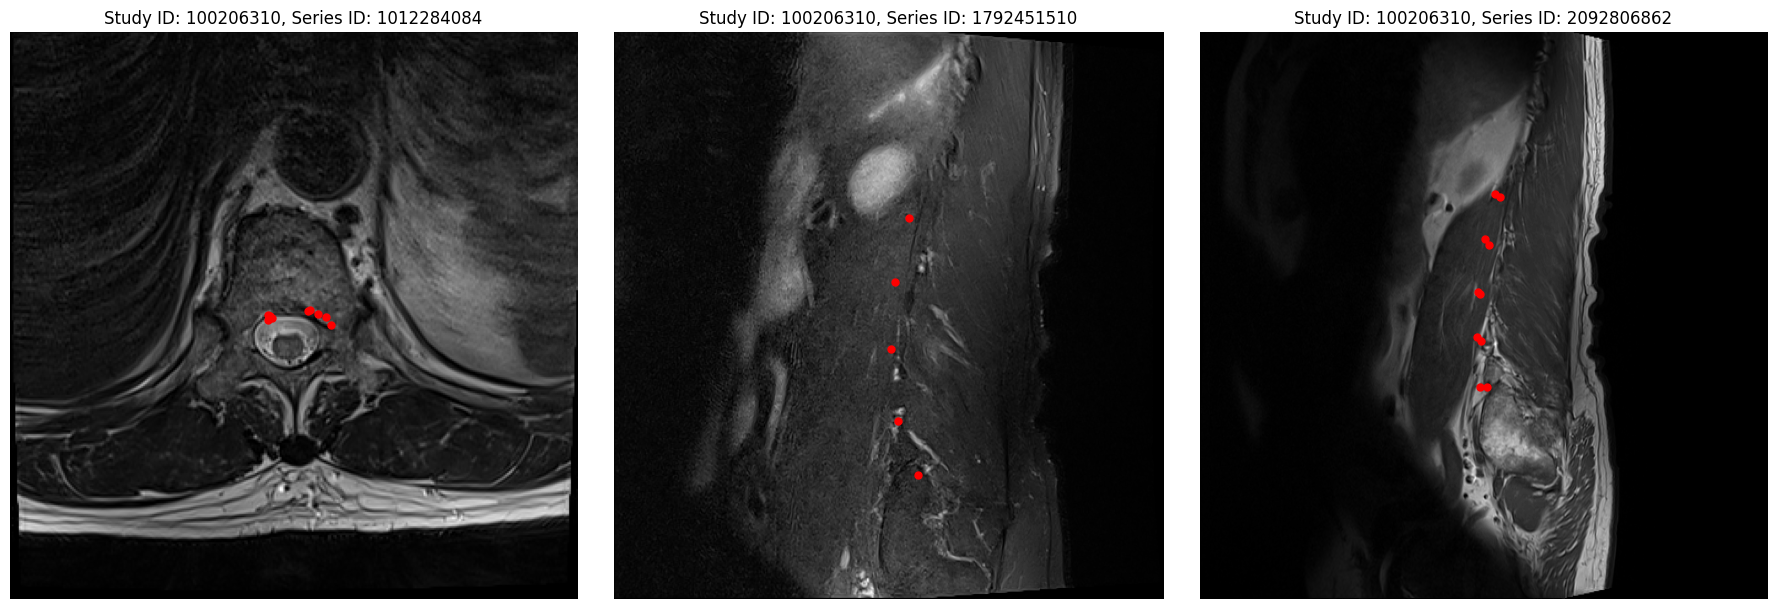

In [20]:
import os
import pydicom
import matplotlib.pyplot as plt
import pandas as pd

# Function to open and display DICOM images along with coordinates
def display_dicom_with_coordinates(image_paths, label_df):
    fig, axs = plt.subplots(1, len(image_paths), figsize=(18, 6))
    
    for idx, path in enumerate(image_paths):  # Display images
        study_id = int(path.split('\\')[-3])
        series_id = int(path.split('\\')[-2])
        
        # Filter label coordinates for the current study and series
        filtered_labels = label_df[(label_df['study_id'] == study_id) & (label_df['series_id'] == series_id)]
        
        # Read DICOM image
        ds = pydicom.dcmread(path)
        
        # Plot DICOM image
        axs[idx].imshow(ds.pixel_array, cmap='gray')
        axs[idx].set_title(f"Study ID: {study_id}, Series ID: {series_id}")
        axs[idx].axis('off')
        
        # Plot coordinates
        for _, row in filtered_labels.iterrows():
            axs[idx].plot(row['x'], row['y'], 'ro', markersize=5)
        
    plt.tight_layout()
    plt.show()

# Load DICOM files from a folder
def load_dicom_files(path_to_folder):
    files = [os.path.join(path_to_folder, f) for f in os.listdir(path_to_folder) if f.endswith('.dcm')]
    files.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('-')[-1]))
    return files

# Display DICOM images with coordinates
study_id = "100206310"
study_folder = f'{train_path}\\train_images\\{study_id}'

image_paths = []
for series_folder in os.listdir(study_folder):
    series_folder_path = os.path.join(study_folder, series_folder)
    dicom_files = load_dicom_files(series_folder_path)
    if dicom_files:
        image_paths.append(dicom_files[0])  # Add the first image from each series


display_dicom_with_coordinates(image_paths, label)

## Data Preprocessing

In [21]:
# Define function to reshape a single row of the DataFrame
def reshape_row(row):
    data = {'study_id': [], 'condition': [], 'level': [], 'severity': []}
    
    for column, value in row.items():
        if column not in ['study_id', 'series_id', 'instance_number', 'x', 'y', 'series_description']:
            parts = column.split('_')
            condition = ' '.join([word.capitalize() for word in parts[:-2]])
            level = parts[-2].capitalize() + '/' + parts[-1].capitalize()
            data['study_id'].append(row['study_id'])
            data['condition'].append(condition)
            data['level'].append(level)
            data['severity'].append(value)
    
    return pd.DataFrame(data)

# Reshape the DataFrame for all rows
new_train_df = pd.concat([reshape_row(row) for _, row in train.iterrows()], ignore_index=True)

# Display the first few rows of the reshaped dataframe
new_train_df.head(5)

,study_id,condition,level,severity
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild


In [22]:
# Print columns in a neat way
print("\nColumns in new_train_df:")
print(",".join(new_train_df.columns))

print("\nColumns in label:")
print(",".join(label.columns))

print("\nColumns in test_desc:")
print(",".join(test_desc.columns))

print("\nColumns in sub:")
print(",".join(sub.columns))


Columns in new_train_df:
study_id,condition,level,severity

Columns in label:
study_id,series_id,instance_number,condition,level,x,y

Columns in test_desc:
study_id,series_id,series_description

Columns in sub:
row_id,normal_mild,moderate,severe


In [23]:
# Merge the dataframes on the common columns
merged_df = pd.merge(new_train_df, label, on=['study_id', 'condition', 'level'], how='inner')
# Merge the dataframes on the common column 'series_id'
final_merged_df = pd.merge(merged_df, train_desc, on='series_id', how='inner')

In [24]:
# Merge the dataframes on the common column 'series_id'
final_merged_df = pd.merge(merged_df, train_desc, on=['series_id','study_id'], how='inner')
# Display the first few rows of the final merged dataframe
final_merged_df.head(5)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2


In [25]:
final_merged_df[final_merged_df['study_id'] == 100206310].sort_values(['x','y'],ascending = True)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
1136,100206310,Right Subarticular Stenosis,L5/S1,Moderate,1012284084,55,145.120536,159.428571,Axial T2
1132,100206310,Right Subarticular Stenosis,L1/L2,Normal/Mild,1012284084,20,145.120536,162.285714,Axial T2
1133,100206310,Right Subarticular Stenosis,L2/L3,Normal/Mild,1012284084,28,145.691964,160.000000,Axial T2
1135,100206310,Right Subarticular Stenosis,L4/L5,Moderate,1012284084,46,146.263393,160.000000,Axial T2
1134,100206310,Right Subarticular Stenosis,L3/L4,Moderate,1012284084,37,147.406250,161.142857,Axial T2
1131,100206310,Left Subarticular Stenosis,L5/S1,Moderate,1012284084,55,167.660739,157.154583,Axial T2
1130,100206310,Left Subarticular Stenosis,L4/L5,Severe,1012284084,46,168.536252,156.279070,Axial T2
1129,100206310,Left Subarticular Stenosis,L3/L4,Moderate,1012284084,37,173.351573,158.467852,Axial T2
1128,100206310,Left Subarticular Stenosis,L2/L3,Normal/Mild,1012284084,28,177.729138,160.218878,Axial T2
1127,100206310,Left Subarticular Stenosis,L1/L2,Normal/Mild,1012284084,20,180.355677,165.034200,Axial T2


In [26]:
final_merged_df[final_merged_df['series_id'] == 1012284084].sort_values("instance_number")

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
1127,100206310,Left Subarticular Stenosis,L1/L2,Normal/Mild,1012284084,20,180.355677,165.034200,Axial T2
1132,100206310,Right Subarticular Stenosis,L1/L2,Normal/Mild,1012284084,20,145.120536,162.285714,Axial T2
1128,100206310,Left Subarticular Stenosis,L2/L3,Normal/Mild,1012284084,28,177.729138,160.218878,Axial T2
1133,100206310,Right Subarticular Stenosis,L2/L3,Normal/Mild,1012284084,28,145.691964,160.000000,Axial T2
1129,100206310,Left Subarticular Stenosis,L3/L4,Moderate,1012284084,37,173.351573,158.467852,Axial T2
1134,100206310,Right Subarticular Stenosis,L3/L4,Moderate,1012284084,37,147.406250,161.142857,Axial T2
1130,100206310,Left Subarticular Stenosis,L4/L5,Severe,1012284084,46,168.536252,156.279070,Axial T2
1135,100206310,Right Subarticular Stenosis,L4/L5,Moderate,1012284084,46,146.263393,160.000000,Axial T2
1131,100206310,Left Subarticular Stenosis,L5/S1,Moderate,1012284084,55,167.660739,157.154583,Axial T2
1136,100206310,Right Subarticular Stenosis,L5/S1,Moderate,1012284084,55,145.120536,159.428571,Axial T2


Now, we can see what the data represents

Series ID 1012284084 contains 60 images, and how each image maps to each level and condition

In [27]:
# Filter the dataframe for the given study_id and sort by instance_number
filtered_df = final_merged_df[final_merged_df['study_id'] == 1013589491].sort_values("instance_number")

# Display the resulting dataframe
filtered_df

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
11430,1013589491,Left Neural Foraminal Narrowing,L5/S1,Normal/Mild,2391548363,6,240.770301,411.216131,Sagittal T1
11445,1013589491,Right Subarticular Stenosis,L5/S1,Normal/Mild,598943280,7,231.484002,293.409742,Axial T2
11440,1013589491,Left Subarticular Stenosis,L5/S1,Normal/Mild,598943280,7,277.947591,296.033812,Axial T2
11429,1013589491,Left Neural Foraminal Narrowing,L4/L5,Normal/Mild,2391548363,7,227.194543,355.943404,Sagittal T1
11428,1013589491,Left Neural Foraminal Narrowing,L3/L4,Normal/Mild,2391548363,7,222.346058,293.844904,Sagittal T1
11426,1013589491,Left Neural Foraminal Narrowing,L1/L2,Normal/Mild,2391548363,7,247.558179,177.458555,Sagittal T1
11427,1013589491,Left Neural Foraminal Narrowing,L2/L3,Normal/Mild,2391548363,7,233.012725,234.685828,Sagittal T1
11421,1013589491,Spinal Canal Stenosis,L1/L2,Normal/Mild,482346415,10,245.476038,189.689334,Sagittal T2
11424,1013589491,Spinal Canal Stenosis,L4/L5,Moderate,482346415,10,238.435979,366.511699,Sagittal T2
11423,1013589491,Spinal Canal Stenosis,L3/L4,Moderate,482346415,10,232.381129,310.201597,Sagittal T2


In [28]:
# Sort final_merged_df by study_id, series_id, and series_description
sorted_final_merged_df = final_merged_df[final_merged_df['study_id'] == 1013589491].sort_values(by=['series_id', 'series_description', 'instance_number'])
sorted_final_merged_df

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
11421,1013589491,Spinal Canal Stenosis,L1/L2,Normal/Mild,482346415,10,245.476038,189.689334,Sagittal T2
11422,1013589491,Spinal Canal Stenosis,L2/L3,Normal/Mild,482346415,10,235.251580,250.434645,Sagittal T2
11423,1013589491,Spinal Canal Stenosis,L3/L4,Moderate,482346415,10,232.381129,310.201597,Sagittal T2
11424,1013589491,Spinal Canal Stenosis,L4/L5,Moderate,482346415,10,238.435979,366.511699,Sagittal T2
11425,1013589491,Spinal Canal Stenosis,L5/S1,Normal/Mild,482346415,10,257.921341,421.652869,Sagittal T2
11440,1013589491,Left Subarticular Stenosis,L5/S1,Normal/Mild,598943280,7,277.947591,296.033812,Axial T2
11445,1013589491,Right Subarticular Stenosis,L5/S1,Normal/Mild,598943280,7,231.484002,293.409742,Axial T2
11439,1013589491,Left Subarticular Stenosis,L4/L5,Moderate,598943280,13,266.694844,257.081995,Axial T2
11444,1013589491,Right Subarticular Stenosis,L4/L5,Normal/Mild,598943280,13,228.060888,255.755492,Axial T2
11438,1013589491,Left Subarticular Stenosis,L3/L4,Moderate,598943280,19,262.366864,246.262046,Axial T2


We see that, <br>
Saggital T1 images map to Neural Foraminal Narrowing <br>
Axial T2 images map to Subarticular Stenosis <br>
Saggital T2/STIR map to Canal Stenosis <br>

In [29]:
import pandas as pd

# Create the row_id column
final_merged_df['row_id'] = (
    final_merged_df['study_id'].astype(str) + '_' +
    final_merged_df['condition'].str.lower().str.replace(' ', '_') + '_' +
    final_merged_df['level'].str.lower().str.replace('/', '_')
)

# Create the image_path column
final_merged_df['image_path'] = (
    f'{train_path}train_images\\' + 
    final_merged_df['study_id'].astype(str) + '\\' +
    final_merged_df['series_id'].astype(str) + '\\' +
    final_merged_df['instance_number'].astype(str) + '.dcm'
)

# Note: Check image path, since there's 1 instance id, for 1 image, but there's many more images other than the ones labelled in the instance ID. 

# Display the updated dataframe
final_merged_df.head(5)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2,4003253_spinal_canal_stenosis_l1_l2,.\data_chaimae\train_images\4003253\702807833\...
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2,4003253_spinal_canal_stenosis_l2_l3,.\data_chaimae\train_images\4003253\702807833\...
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2,4003253_spinal_canal_stenosis_l3_l4,.\data_chaimae\train_images\4003253\702807833\...
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2,4003253_spinal_canal_stenosis_l4_l5,.\data_chaimae\train_images\4003253\702807833\...
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2,4003253_spinal_canal_stenosis_l5_s1,.\data_chaimae\train_images\4003253\702807833\...


In [30]:
final_merged_df[final_merged_df["severity"] == "Normal/Mild"].value_counts().sum()

37626

In [31]:
final_merged_df[final_merged_df["severity"] == "Moderate"].value_counts().sum()

7950

In [32]:
# Define the base path for test images
base_path = '.\\data_chaimae\\test_images\\'

# Function to get image paths for a series
def get_image_paths(row):
    series_path = os.path.join(base_path, str(row['study_id']), str(row['series_id']))
    if os.path.exists(series_path):
        return [os.path.join(series_path, f) for f in os.listdir(series_path) if os.path.isfile(os.path.join(series_path, f))]
    return []

# Mapping of series_description to conditions
condition_mapping = {
    'Sagittal T1': {'left': 'left_neural_foraminal_narrowing', 'right': 'right_neural_foraminal_narrowing'},
    'Axial T2': {'left': 'left_subarticular_stenosis', 'right': 'right_subarticular_stenosis'},
    'Sagittal T2': 'spinal_canal_stenosis'
}

# Create a list to store the expanded rows
expanded_rows = []

# Expand the dataframe by adding new rows for each file path
for index, row in test_desc.iterrows():
    image_paths = get_image_paths(row)
    conditions = condition_mapping.get(row['series_description'], {})
    if isinstance(conditions, str):  # Single condition
        conditions = {'left': conditions, 'right': conditions}
    for side, condition in conditions.items():
        for image_path in image_paths:
            expanded_rows.append({
                'study_id': row['study_id'],
                'series_id': row['series_id'],
                'series_description': row['series_description'],
                'image_path': image_path,
                'condition': condition,
                'row_id': f"{row['study_id']}_{condition}"
            })

# Create a new dataframe from the expanded rows
expanded_test_desc = pd.DataFrame(expanded_rows)

# Display the resulting dataframe
expanded_test_desc.head(5)

,study_id,series_id,series_description,image_path,condition,row_id
0,44036939,2828203845,Sagittal T1,.\data_chaimae\test_images\44036939\2828203845...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
1,44036939,2828203845,Sagittal T1,.\data_chaimae\test_images\44036939\2828203845...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
2,44036939,2828203845,Sagittal T1,.\data_chaimae\test_images\44036939\2828203845...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
3,44036939,2828203845,Sagittal T1,.\data_chaimae\test_images\44036939\2828203845...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
4,44036939,2828203845,Sagittal T1,.\data_chaimae\test_images\44036939\2828203845...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing


In [33]:
# change severity column labels
#Normal/Mild': 'normal_mild', 'Moderate': 'moderate', 'Severe': 'severe'}
final_merged_df['severity'] = final_merged_df['severity'].map({'Normal/Mild': 'normal_mild', 'Moderate': 'moderate', 'Severe': 'severe'})

In [34]:
test_data = expanded_test_desc
train_data = final_merged_df

In [35]:
import os

# Define a function to check if a path exists
def check_exists(path):
    return os.path.exists(path)

# Define a function to check if a study ID directory exists
def check_study_id(row):
    study_id = row['study_id']
    path = f'{train_path}train_images\\{study_id}'
    return check_exists(path)

# Define a function to check if a series ID directory exists
def check_series_id(row):
    study_id = row['study_id']
    series_id = row['series_id']
    path = f'{train_path}\\train_images\\{study_id}\\{series_id}'
    return check_exists(path)

# Define a function to check if an image file exists
def check_image_exists(row):
    image_path = row['image_path']
    return check_exists(image_path)

# Apply the functions to the train_data dataframe
train_data['study_id_exists'] = train_data.apply(check_study_id, axis=1)
train_data['series_id_exists'] = train_data.apply(check_series_id, axis=1)
train_data['image_exists'] = train_data.apply(check_image_exists, axis=1)

# Filter train_data
train_data = train_data[(train_data['study_id_exists']) & (train_data['series_id_exists']) & (train_data['image_exists'])]

In [36]:
train_data.head(3)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path,study_id_exists,series_id_exists,image_exists
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2,4003253_spinal_canal_stenosis_l1_l2,.\data_chaimae\train_images\4003253\702807833\...,True,True,True
1,4003253,Spinal Canal Stenosis,L2/L3,normal_mild,702807833,8,320.571429,295.714286,Sagittal T2,4003253_spinal_canal_stenosis_l2_l3,.\data_chaimae\train_images\4003253\702807833\...,True,True,True
2,4003253,Spinal Canal Stenosis,L3/L4,normal_mild,702807833,8,323.030303,371.818182,Sagittal T2,4003253_spinal_canal_stenosis_l3_l4,.\data_chaimae\train_images\4003253\702807833\...,True,True,True


In [37]:
def load_dicom(path):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

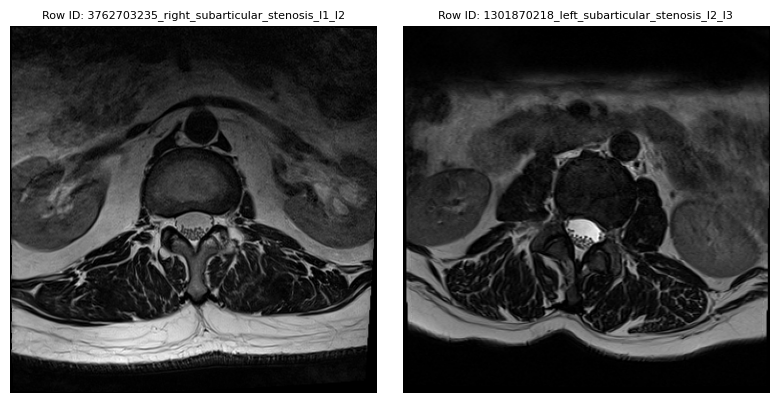

In [38]:
# Load images randomly
import random
images = []
row_ids = []
selected_indices = random.sample(range(len(train_data)), 2)
for i in selected_indices:
    image = load_dicom(train_data['image_path'][i])
    images.append(image)
    row_ids.append(train_data['row_id'][i])

# Plot images
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
    ax[i].imshow(images[i], cmap='gray')
    ax[i].set_title(f'Row ID: {row_ids[i]}', fontsize=8)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## Loading data

In [209]:
#for one hot encoding
#train_data[['normal_mild', 'severe', 'moderate']] = train_data[['normal_mild', 'severe', 'moderate']].astype(int)  

In [39]:
train_data

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path,study_id_exists,series_id_exists,image_exists
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2,4003253_spinal_canal_stenosis_l1_l2,.\data_chaimae\train_images\4003253\702807833\...,True,True,True
1,4003253,Spinal Canal Stenosis,L2/L3,normal_mild,702807833,8,320.571429,295.714286,Sagittal T2,4003253_spinal_canal_stenosis_l2_l3,.\data_chaimae\train_images\4003253\702807833\...,True,True,True
2,4003253,Spinal Canal Stenosis,L3/L4,normal_mild,702807833,8,323.030303,371.818182,Sagittal T2,4003253_spinal_canal_stenosis_l3_l4,.\data_chaimae\train_images\4003253\702807833\...,True,True,True
3,4003253,Spinal Canal Stenosis,L4/L5,normal_mild,702807833,8,335.292035,427.327434,Sagittal T2,4003253_spinal_canal_stenosis_l4_l5,.\data_chaimae\train_images\4003253\702807833\...,True,True,True
4,4003253,Spinal Canal Stenosis,L5/S1,normal_mild,702807833,8,353.415929,483.964602,Sagittal T2,4003253_spinal_canal_stenosis_l5_s1,.\data_chaimae\train_images\4003253\702807833\...,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48687,4290709089,Right Subarticular Stenosis,L1/L2,normal_mild,3390218084,2,307.180844,354.869960,Axial T2,4290709089_right_subarticular_stenosis_l1_l2,.\data_chaimae\train_images\4290709089\3390218...,True,True,True
48688,4290709089,Right Subarticular Stenosis,L2/L3,normal_mild,3390218084,6,301.440933,362.044847,Axial T2,4290709089_right_subarticular_stenosis_l2_l3,.\data_chaimae\train_images\4290709089\3390218...,True,True,True
48689,4290709089,Right Subarticular Stenosis,L3/L4,normal_mild,3390218084,10,302.875911,356.304937,Axial T2,4290709089_right_subarticular_stenosis_l3_l4,.\data_chaimae\train_images\4290709089\3390218...,True,True,True
48690,4290709089,Right Subarticular Stenosis,L4/L5,normal_mild,3390218084,15,305.745866,340.520184,Axial T2,4290709089_right_subarticular_stenosis_l4_l5,.\data_chaimae\train_images\4290709089\3390218...,True,True,True


In [40]:
train_data = train_data.dropna()

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import torch
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image_path = self.dataframe['image_path'][index]
        image = load_dicom(image_path)  # Define this function to load your DICOM images
        label = self.dataframe['severity'][index]
        
        if self.transform:
            image = self.transform(image)

        return image, label

# Function to create datasets and dataloaders for each series description
def create_datasets_and_loaders(df, series_description, transform, batch_size=32):
    filtered_df = df[df['series_description'] == series_description]
    
    train_df, val_df = train_test_split(filtered_df, test_size=0.2, random_state=42)
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)

    train_dataset = CustomDataset(train_df, transform)
    val_dataset = CustomDataset(val_df, transform)

    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return trainloader, valloader, len(train_df), len(val_df)

# Define the transforms

transform = transforms.Compose([
    transforms.Lambda(lambda x: (x * 255).astype(np.uint8)),  # Convert back to uint8 for PIL
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomCrop(size=(220, 220), padding=10),
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])


# Apply this transform in your dataset class


# Create dataloaders for each series description
dataloaders = {}
lengths = {}

trainloader_t1, valloader_t1, len_train_t1, len_val_t1 = create_datasets_and_loaders(train_data, 'Sagittal T1', transform)
trainloader_t2, valloader_t2, len_train_t2, len_val_t2 = create_datasets_and_loaders(train_data, 'Axial T2', transform)
trainloader_t2stir, valloader_t2stir, len_train_t2stir, len_val_t2stir = create_datasets_and_loaders(train_data, 'Sagittal T2', transform)

dataloaders['Sagittal T1'] = (trainloader_t1, valloader_t1)
dataloaders['Axial T2'] = (trainloader_t2, valloader_t2)
dataloaders['Sagittal T2'] = (trainloader_t2stir, valloader_t2stir)

lengths['Sagittal T1'] = (len_train_t1, len_val_t1)
lengths['Axial T2'] = (len_train_t2, len_val_t2)
lengths['Sagittal T2'] = (len_train_t2stir, len_val_t2stir)

# Dictionary mapping labels to indices
label_map = {'Mild': 0, 'Moderate': 1, 'Severe': 2}

Visualizing Sagittal T1 samples


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

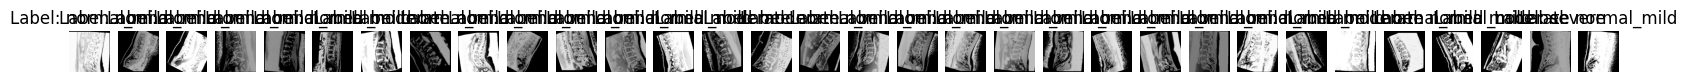

Visualizing Axial T2 samples


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

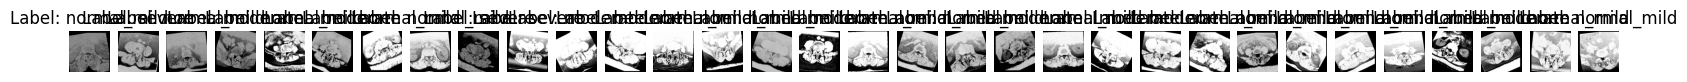

Visualizing Sagittal T2 samples


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

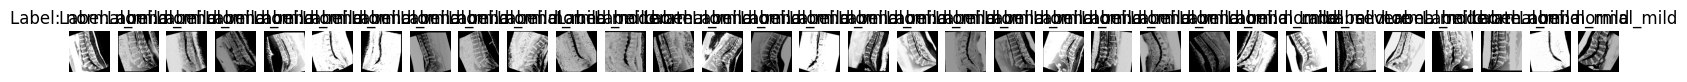

In [213]:
import matplotlib.pyplot as plt

# Function to visualize a batch of images
def visualize_batch(dataloader):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    for i, (img, lbl) in enumerate(zip(images, labels)):
        ax = axes[i]
        img = img.permute(1, 2, 0)  # Convert to HWC for visualization
        ax.imshow(img)
        ax.set_title(f"Label: {lbl}")
        ax.axis('off')
    plt.show()

# Visualize samples from each dataloader
print("Visualizing Sagittal T1 samples")
visualize_batch(trainloader_t1)
print("Visualizing Axial T2 samples")
visualize_batch(trainloader_t2)
print("Visualizing Sagittal T2 samples")
visualize_batch(trainloader_t2stir)

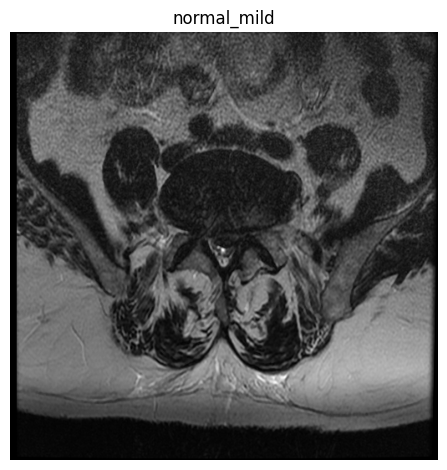

In [214]:
import matplotlib.pyplot as plt

image, label = next(iter(trainloader_t2))
sample = image[1].permute(1, 2, 0)  #sample

# Plot images
plt.figsize=(8, 4)
plt.imshow(images[0], cmap='gray')
plt.title(label[0])
plt.axis('off')
plt.tight_layout()
plt.show()

## Model

ConvNext

In [42]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
import torch
import torch.nn as nn
from torchvision import models

class CustomInceptionV3(nn.Module):
    def __init__(self, num_classes=3, pretrained=True):
        super(CustomInceptionV3, self).__init__()
        # Load the Inception v3 model without pretrained weights
        self.model = models.inception_v3(weights='DEFAULT',aux_logits=True)
        self.model.aux_logits = False
        self.model.AuxLogits = None
        # Replace the last fully connected layer
        num_ftrs = self.model.fc.in_features  # Access the final fully connected layer
        self.model.fc = nn.Linear(num_ftrs, num_classes)  # Replace with new output layer for num_classes
        

    def forward(self, x):
        return self.model(x)

    def unfreeze_model(self):
        # Unfreeze all layers except BatchNorm layers
        for layer in self.model.children():
            if not isinstance(layer, nn.BatchNorm2d):
                for param in layer.parameters():
                    param.requires_grad = True
        
        # Unfreeze the final fully connected layer
        for param in self.model.fc.parameters():
            param.requires_grad = True

# Check for device availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models with weights from the specified path
#weights_path = '/kaggle/input/inceptionv3/pytorch/default/1/inception_v3_google-0cc3c7bd.pth'
Isagittal_t1_model = CustomInceptionV3(num_classes=3, pretrained=True).to(device)
Iaxial_t2_model = CustomInceptionV3(num_classes=3, pretrained=True).to(device)
Isagittal_t2stir_model = CustomInceptionV3(num_classes=3, pretrained=True).to(device)

# Optionally freeze initial layers
for model in [Isagittal_t1_model, Iaxial_t2_model, Isagittal_t2stir_model]:
    for param in model.model.Conv2d_1a_3x3.parameters():  # Freeze the first convolutional layer
        param.requires_grad = False

# Unfreeze the final fully connected layer
for model in [Isagittal_t1_model, Iaxial_t2_model, Isagittal_t2stir_model]:
    for param in model.model.fc.parameters():
        param.requires_grad = True

# Training parameters
criterion = nn.CrossEntropyLoss()

# Initialize separate optimizers for each model
optimizer_Isagittal_t1 = torch.optim.Adam(Isagittal_t1_model.parameters(), lr=1e-4)  # Pass all parameters
optimizer_Iaxial_t2 = torch.optim.Adam(Iaxial_t2_model.parameters(), lr=1e-4)
optimizer_Isagittal_t2stir = torch.optim.Adam(Isagittal_t2stir_model.parameters(), lr=1e-4)

# Store the models and optimizers in dictionaries for easy access
models_dict = {
    'Sagittal T1': Isagittal_t1_model,
    'Axial T2': Iaxial_t2_model,
    'Sagittal T2': Isagittal_t2stir_model,
}
optimizers_dict = {
    'Sagittal T1': optimizer_Isagittal_t1,
    'Axial T2': optimizer_Iaxial_t2,
    'Sagittal T2': optimizer_Isagittal_t2stir,
}


In [217]:
# Count trainable parameters
trainable_params = sum(p.numel() for p in Isagittal_t1_model.parameters() if p.requires_grad)
print(f"Number of parameters: {trainable_params}")

Number of parameters: 21790787


## Training

In [44]:


label_map = {'normal_mild': 0, 'moderate': 1, 'severe': 2}  # Example label mapping



In [219]:
def train_model(model, trainloader, valloader, len_train, len_val, optimizer, desc, num_epochs=10, patience=3, save_dir='./models'):
    # Create a directory for the specific model (e.g., Inception_V3)
    model_name = model.__class__.__name__
    model_save_dir = os.path.join(save_dir, f'{model_name}_{desc}')  # e.g., './models/Inception_V3_ISagittal_T1'
    os.makedirs(model_save_dir, exist_ok=True)

    # Learning rate scheduler
    scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
    
    best_val_acc = 0.0
    best_model_wts = deepcopy(model.state_dict())
    counter = 0
    last_improvement_epoch = 0  # Track the epoch when last improvement occurred
    roc_filename = os.path.join(model_save_dir, f'roc_curve_{model_name}_{desc}.png')  # Filename for ROC curve

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        
        # Training loop
        with tqdm(trainloader, unit="batch") as tepoch:
            for images, labels in tepoch:
                images, labels = images.to(device), torch.tensor([label_map[label] for label in labels]).to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                
                probabilities = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(probabilities, 1)
                correct_train += (predicted == labels).sum().item()
                
                tepoch.set_postfix(epoch=epoch+1)
        
        scheduler.step()
        
        train_loss /= len(trainloader)
        train_acc = 100 * correct_train / len_train
        
        # Validation loop
        model.eval()
        val_loss, correct_val = 0, 0
        y_true_val = []
        y_scores_val = []
        
        with torch.no_grad():
            with tqdm(valloader, unit="batch") as vepoch:
                for images, labels in vepoch:
                    images, labels = images.to(device), torch.tensor([label_map[label] for label in labels]).to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    
                    probabilities = torch.softmax(outputs, dim=1)
                    _, predicted = torch.max(probabilities, 1)
                    correct_val += (predicted == labels).sum().item()
                    
                    # Collect true labels and probabilities for ROC (validation only)
                    y_true_val.append(labels.cpu().numpy())
                    y_scores_val.append(probabilities.cpu().detach().numpy())
                    
                    vepoch.set_postfix(epoch=epoch+1)
        
        val_loss /= len(valloader)
        val_acc = 100 * correct_val / len_val
        
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Save the model only when validation accuracy improves
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = deepcopy(model.state_dict())
            last_improvement_epoch = epoch  # Update the epoch of the last improvement
            counter = 0  # Reset counter when an improvement happens
        else:
            counter += 1
            # Early stopping triggered if no improvement for 'patience' epochs
            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

    # After the last improvement (or early stopping), save the best model and ROC curve
    model_path = os.path.join(model_save_dir, f'best_{model_name}_{desc}.pth')
    torch.save(best_model_wts, model_path)
    print(f"Best model saved to {model_path} from epoch {last_improvement_epoch + 1}")
    
    # Save the ROC curve for the validation set
    y_true_val = np.concatenate(y_true_val)
    y_scores_val = np.concatenate(y_scores_val)
    
    # If multi-class, use one-hot encoding for true labels
    if len(set(y_true_val)) > 2:  # Check for multi-class
        y_true_one_hot = np.zeros((y_true_val.size, len(label_map)))
        y_true_one_hot[np.arange(y_true_val.size), y_true_val] = 1
        plot_roc_curve(y_true_one_hot, y_scores_val, list(label_map.keys()), roc_filename)

    # Load best model weights (from last improvement)
    model.load_state_dict(best_model_wts)
    return model, best_val_acc

In [220]:
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_scores, class_names, filename):
    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve of class {class_names[i]} (area = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess (area = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) curves')
    plt.legend(loc='lower right')
    plt.savefig(filename)
    plt.close()

# Training all models
for desc, model in models_dict.items():
    if desc == 'Sagittal T1':
        trainloader, valloader, len_train, len_val = trainloader_t1, valloader_t1, len_train_t1, len_val_t1
    elif desc == 'Axial T2':
        trainloader, valloader, len_train, len_val = trainloader_t2, valloader_t2, len_train_t2, len_val_t2
    elif desc == 'Sagittal T2':
        trainloader, valloader, len_train, len_val = trainloader_t2stir, valloader_t2stir, len_train_t2stir, len_val_t2stir
    
    train_model(model, trainloader, valloader, len_train, len_val, optimizers_dict[desc], desc)  # Pass desc to differentiate

100%|████████████████████████████████████████████████████████████████████| 124/124 [01:48<00:00,  1.14batch/s, epoch=1]


Epoch 1, Train Loss: 0.6168, Train Acc: 77.27%, Val Loss: 0.5686, Val Acc: 78.40%


100%|████████████████████████████████████████████████████████████████████| 124/124 [01:48<00:00,  1.15batch/s, epoch=2]


Epoch 2, Train Loss: 0.5678, Train Acc: 77.81%, Val Loss: 0.5509, Val Acc: 78.78%


100%|████████████████████████████████████████████████████████████████████| 124/124 [01:49<00:00,  1.13batch/s, epoch=3]


Epoch 3, Train Loss: 0.5439, Train Acc: 78.03%, Val Loss: 0.5391, Val Acc: 78.93%


100%|████████████████████████████████████████████████████████████████████| 124/124 [01:47<00:00,  1.15batch/s, epoch=4]


Epoch 4, Train Loss: 0.5346, Train Acc: 78.31%, Val Loss: 0.5335, Val Acc: 79.00%


100%|████████████████████████████████████████████████████████████████████| 124/124 [01:46<00:00,  1.16batch/s, epoch=5]


Epoch 5, Train Loss: 0.5295, Train Acc: 78.49%, Val Loss: 0.5284, Val Acc: 78.98%


100%|████████████████████████████████████████████████████████████████████| 124/124 [01:46<00:00,  1.16batch/s, epoch=6]


Epoch 6, Train Loss: 0.5298, Train Acc: 78.32%, Val Loss: 0.5304, Val Acc: 79.44%


100%|████████████████████████████████████████████████████████████████████| 124/124 [01:47<00:00,  1.15batch/s, epoch=7]


Epoch 7, Train Loss: 0.5258, Train Acc: 78.64%, Val Loss: 0.5342, Val Acc: 78.85%


100%|████████████████████████████████████████████████████████████████████| 124/124 [01:46<00:00,  1.16batch/s, epoch=8]


Epoch 8, Train Loss: 0.5286, Train Acc: 78.31%, Val Loss: 0.5357, Val Acc: 78.98%


100%|████████████████████████████████████████████████████████████████████| 124/124 [01:49<00:00,  1.13batch/s, epoch=9]


Epoch 9, Train Loss: 0.5300, Train Acc: 78.34%, Val Loss: 0.5394, Val Acc: 78.93%
Early stopping triggered after 9 epochs
Best model saved to ./models\CustomInceptionV3_Sagittal T1\best_CustomInceptionV3_Sagittal T1.pth from epoch 6


100%|████████████████████████████████████████████████████████████████████| 121/121 [01:27<00:00,  1.38batch/s, epoch=1]


Epoch 1, Train Loss: 0.5653, Train Acc: 75.65%, Val Loss: 0.4893, Val Acc: 78.53%


100%|████████████████████████████████████████████████████████████████████| 121/121 [01:47<00:00,  1.13batch/s, epoch=2]


Epoch 2, Train Loss: 0.4901, Train Acc: 78.61%, Val Loss: 0.4784, Val Acc: 78.84%


100%|████████████████████████████████████████████████████████████████████| 121/121 [01:27<00:00,  1.38batch/s, epoch=3]


Epoch 3, Train Loss: 0.4526, Train Acc: 79.75%, Val Loss: 0.4577, Val Acc: 79.83%


100%|████████████████████████████████████████████████████████████████████| 121/121 [01:27<00:00,  1.39batch/s, epoch=4]


Epoch 4, Train Loss: 0.4476, Train Acc: 80.01%, Val Loss: 0.4626, Val Acc: 78.87%


100%|████████████████████████████████████████████████████████████████████| 121/121 [01:27<00:00,  1.38batch/s, epoch=5]


Epoch 5, Train Loss: 0.4401, Train Acc: 80.52%, Val Loss: 0.4599, Val Acc: 79.37%


100%|████████████████████████████████████████████████████████████████████| 121/121 [01:26<00:00,  1.39batch/s, epoch=6]


Epoch 6, Train Loss: 0.4374, Train Acc: 80.58%, Val Loss: 0.4609, Val Acc: 79.03%
Early stopping triggered after 6 epochs
Best model saved to ./models\CustomInceptionV3_Axial T2\best_CustomInceptionV3_Axial T2.pth from epoch 3


100%|██████████████████████████████████████████████████████████████████████| 61/61 [01:09<00:00,  1.14s/batch, epoch=1]


Epoch 1, Train Loss: 0.4210, Train Acc: 86.79%, Val Loss: 0.3995, Val Acc: 87.08%


100%|██████████████████████████████████████████████████████████████████████| 61/61 [01:10<00:00,  1.15s/batch, epoch=2]


Epoch 2, Train Loss: 0.3700, Train Acc: 87.80%, Val Loss: 0.3754, Val Acc: 87.13%


100%|██████████████████████████████████████████████████████████████████████| 61/61 [01:08<00:00,  1.12s/batch, epoch=3]


Epoch 3, Train Loss: 0.3492, Train Acc: 87.84%, Val Loss: 0.3699, Val Acc: 87.13%


100%|██████████████████████████████████████████████████████████████████████| 61/61 [01:08<00:00,  1.13s/batch, epoch=4]


Epoch 4, Train Loss: 0.3412, Train Acc: 87.84%, Val Loss: 0.3687, Val Acc: 87.13%


100%|██████████████████████████████████████████████████████████████████████| 61/61 [01:09<00:00,  1.14s/batch, epoch=5]


Epoch 5, Train Loss: 0.3371, Train Acc: 87.82%, Val Loss: 0.3747, Val Acc: 87.18%


100%|██████████████████████████████████████████████████████████████████████| 61/61 [01:08<00:00,  1.13s/batch, epoch=6]


Epoch 6, Train Loss: 0.3381, Train Acc: 87.79%, Val Loss: 0.3700, Val Acc: 87.13%


100%|██████████████████████████████████████████████████████████████████████| 61/61 [01:09<00:00,  1.14s/batch, epoch=7]


Epoch 7, Train Loss: 0.3348, Train Acc: 87.83%, Val Loss: 0.3743, Val Acc: 87.23%


100%|██████████████████████████████████████████████████████████████████████| 61/61 [01:16<00:00,  1.26s/batch, epoch=8]


Epoch 8, Train Loss: 0.3382, Train Acc: 87.86%, Val Loss: 0.3689, Val Acc: 87.08%


100%|██████████████████████████████████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/batch, epoch=9]


Epoch 9, Train Loss: 0.3373, Train Acc: 87.84%, Val Loss: 0.3677, Val Acc: 87.13%


100%|█████████████████████████████████████████████████████████████████████| 61/61 [01:15<00:00,  1.24s/batch, epoch=10]


Epoch 10, Train Loss: 0.3372, Train Acc: 87.86%, Val Loss: 0.3724, Val Acc: 87.08%
Early stopping triggered after 10 epochs
Best model saved to ./models\CustomInceptionV3_Sagittal T2\best_CustomInceptionV3_Sagittal T2.pth from epoch 7


In [4]:
import matplotlib.pyplot as plt

# Example data for three models (replace with your actual values)
epochs_model1 = list(range(1, 10))  # 9 epochs for model 1
val_loss_model1 = [0.5686, 0.5509, 0.5391, 0.5335, 0.5284, 0.5304, 0.5342, 0.5357, 0.5394]
val_acc_model1 = [78.40, 78.78, 78.93, 79.00, 78.98, 79.44, 78.85, 78.98, 78.93]

epochs_model2 = list(range(1, 7))  # 6 epochs for model 2
val_loss_model2 = [0.4893, 0.4784, 0.4577, 0.4626, 0.4599, 0.4609]
val_acc_model2 = [78.53, 78.84, 79.83, 78.87, 79.37, 79.03]

epochs_model3 = list(range(1, 7))  # 6 epochs for model 3
val_loss_model3 = [0.3995, 0.3754, 0.3699, 0.3687, 0.3747, 0.3747]
val_acc_model3 = [87.08, 87.13, 87.13, 87.13, 87.18, 87.18]

# Plot and save Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_model1, val_loss_model1, label='Model 1: Sagittal T1', marker='o')
plt.plot(epochs_model2, val_loss_model2, label='Model 2: Axial T2', marker='o')
plt.plot(epochs_model3, val_loss_model3, label='Model 3: Sagittal T2', marker='o')

plt.title('IncenptionV3 Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('IncenptionV3_validation_loss.png', dpi=300)
plt.close()  # Close the figure to free up memory
print("Validation loss plot saved as 'IncenptionV3_validation_loss.png'.")

# Plot and save Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_model1, val_acc_model1, label='Model 1: Sagittal T1', marker='o')
plt.plot(epochs_model2, val_acc_model2, label='Model 2: Axial T2', marker='o')
plt.plot(epochs_model3, val_acc_model3, label='Model 3: Sagittal T2', marker='o')

plt.title('IncenptionV3 Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('IncenptionV3_validation_accuracy.png', dpi=300)
plt.close()  # Close the figure to free up memory
print("Validation accuracy plot saved as 'IncenptionV3_validation_accuracy.png'.")


Validation loss plot saved as 'IncenptionV3_validation_loss.png'.
Validation accuracy plot saved as 'IncenptionV3_validation_accuracy.png'.


In [5]:
import matplotlib.pyplot as plt

# Training data for three models
epochs_model1 = list(range(1, 10))  # 9 epochs for model 1
train_loss_model1 = [0.6168, 0.5678, 0.5439, 0.5346, 0.5295, 0.5298, 0.5258, 0.5286, 0.5300]
train_acc_model1 = [77.27, 77.81, 78.03, 78.31, 78.49, 78.32, 78.64, 78.31, 78.34]

epochs_model2 = list(range(1, 7))  # 6 epochs for model 2
train_loss_model2 = [0.5653, 0.4901, 0.4526, 0.4476, 0.4401, 0.4374]
train_acc_model2 = [75.65, 78.61, 79.75, 80.01, 80.52, 80.58]

epochs_model3 = list(range(1, 7))  # 6 epochs for model 3
train_loss_model3 = [0.4210, 0.3700, 0.3492, 0.3412, 0.3371, 0.3371]
train_acc_model3 = [86.79, 87.80, 87.84, 87.84, 87.82, 87.82]

# Plot and save Training Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_model1, train_loss_model1, label='Model 1: Sagittal T1', marker='o')
plt.plot(epochs_model2, train_loss_model2, label='Model 2: Axial T2', marker='o')
plt.plot(epochs_model3, train_loss_model3, label='Model 3: Sagittal T2', marker='o')

plt.title('IncenptionV3 Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('IncenptionV3_training_loss.png', dpi=300)
plt.close()  # Close the figure to free up memory
print("Training loss plot saved as 'IncenptionV3_training_loss.png'.")

# Plot and save Training Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_model1, train_acc_model1, label='Model 1: Sagittal T1', marker='o')
plt.plot(epochs_model2, train_acc_model2, label='Model 2: Axial T2', marker='o')
plt.plot(epochs_model3, train_acc_model3, label='Model 3: Sagittal T2', marker='o')

plt.title('IncenptionV3 Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('IncenptionV3_training_accuracy.png', dpi=300)
plt.close()  # Close the figure to free up memory
print("Training accuracy plot saved as 'IncenptionV3_training_accuracy.png'.")


Training loss plot saved as 'IncenptionV3_training_loss.png'.
Training accuracy plot saved as 'IncenptionV3_training_accuracy.png'.


In [45]:
from sklearn.metrics import f1_score, recall_score

def evaluate_model(model, valloader, label_map):
    model.eval()  # Set the model to evaluation mode
    correct_val = 0
    y_true_val = []
    y_scores_val = []

    with torch.no_grad():
        with tqdm(valloader, unit="batch") as vepoch:
            for images, labels in vepoch:
                images, labels = images.to(device), torch.tensor([label_map[label] for label in labels]).to(device)
                outputs = model(images)
                
                probabilities = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(probabilities, 1)
                correct_val += (predicted == labels).sum().item()
                
                # Collect true labels and probabilities for metrics
                y_true_val.extend(labels.cpu().numpy())
                y_scores_val.extend(probabilities.cpu().detach().numpy())

                vepoch.set_postfix()
    
    # Convert to numpy arrays for metric calculations
    y_true_val = np.array(y_true_val)
    y_scores_val = np.array(y_scores_val)
    
    # Calculate F1-score and Recall
    f1 = f1_score(y_true_val, np.argmax(y_scores_val, axis=1), average='weighted')
    recall = recall_score(y_true_val, np.argmax(y_scores_val, axis=1), average='weighted')
    
    val_acc = 100 * correct_val / len(valloader.dataset)  # Total number of samples in validation set
    
    print(f"Validation Accuracy: {val_acc:.2f}%, F1 Score: {f1:.4f}, Recall: {recall:.4f}")
    return f1, recall

In [46]:
import torch

# Load the trained models
model_CustomInceptionV3_SagittalT1_path = 'models/CustomInceptionV3_Sagittal T1/best_CustomInceptionV3_Sagittal T1.pth'
model_CustomInceptionV3_AxialT2_path = 'models/CustomInceptionV3_Axial T2/best_CustomInceptionV3_Axial T2.pth'
model_CustomInceptionV3_SagittalT2_path = 'models/CustomInceptionV3_Sagittal T2/best_CustomInceptionV3_Sagittal T2.pth'

num_classes = len(label_map)  # Replace with your actual number of classes

# Dictionary to map descriptions to model paths
model_paths = {
    'Sagittal T1': model_CustomInceptionV3_SagittalT1_path,
    'Axial T2': model_CustomInceptionV3_AxialT2_path,
    'Sagittal T2': model_CustomInceptionV3_SagittalT2_path
}

# Initialize models and load weights
loaded_models = {}
for desc, model_path in model_paths.items():
    # Create a new instance of CustomResNet for each model
    model = CustomInceptionV3(num_classes=num_classes, pretrained=False)  # Use pretrained=False since you're loading weights

    # Load the state dict
    model.load_state_dict(torch.load(model_path, map_location=device))  # Load to the appropriate device
    model.to(device)  # Move the model to the appropriate device (CPU or GPU)

    # Store the loaded model in a dictionary
    loaded_models[desc] = model

    # Get the validation data loader
    trainloader, valloader = dataloaders[desc]  # Use the appropriate key for the dataloaders

    # Evaluate the loaded model
    f1, recall = evaluate_model(model, valloader, label_map)

    print(f"Evaluation results for {desc}: F1 Score: {f1}, Recall: {recall}")

100%|█████████████████████████████████████████████████████████████████████████████| 124/124 [01:14<00:00,  1.67batch/s]


Validation Accuracy: 79.06%, F1 Score: 0.7326, Recall: 0.7906
Evaluation results for Sagittal T1: F1 Score: 0.7326338581188209, Recall: 0.7905559786747905


100%|█████████████████████████████████████████████████████████████████████████████| 121/121 [01:03<00:00,  1.92batch/s]


Validation Accuracy: 79.37%, F1 Score: 0.7844, Recall: 0.7937
Evaluation results for Axial T2: F1 Score: 0.7844409667453904, Recall: 0.7936507936507936


100%|███████████████████████████████████████████████████████████████████████████████| 61/61 [00:35<00:00,  1.72batch/s]

Validation Accuracy: 87.23%, F1 Score: 0.8140, Recall: 0.8723
Evaluation results for Sagittal T2: F1 Score: 0.8140311943994945, Recall: 0.8723076923076923


## Inference

In [221]:
train_data['level'].unique()

array(['L1/L2', 'L2/L3', 'L3/L4', 'L4/L5', 'L5/S1'], dtype=object)

In [222]:
expanded_test_desc.head(5)

,study_id,series_id,series_description,image_path,condition,row_id
0,44036939,2828203845,Sagittal T1,.\data_chaimae\test_images\44036939\2828203845...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
1,44036939,2828203845,Sagittal T1,.\data_chaimae\test_images\44036939\2828203845...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
2,44036939,2828203845,Sagittal T1,.\data_chaimae\test_images\44036939\2828203845...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
3,44036939,2828203845,Sagittal T1,.\data_chaimae\test_images\44036939\2828203845...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
4,44036939,2828203845,Sagittal T1,.\data_chaimae\test_images\44036939\2828203845...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing


In [223]:
levels = ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']

# Function to update row_id with levels
def update_row_id(row, levels):
    level = levels[row.name % len(levels)]
    return f"{row['study_id']}_{row['condition']}_{level}"

# Update row_id in expanded_test_desc to include levels
expanded_test_desc['row_id'] = expanded_test_desc.apply(lambda row: update_row_id(row, levels), axis=1)

In [224]:
expanded_test_desc.head(2)

,study_id,series_id,series_description,image_path,condition,row_id
0,44036939,2828203845,Sagittal T1,.\data_chaimae\test_images\44036939\2828203845...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing_l1_l2
1,44036939,2828203845,Sagittal T1,.\data_chaimae\test_images\44036939\2828203845...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing_l2_l3


In [225]:
# Define a custom test dataset class
class TestDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image_path = self.dataframe['image_path'][index]
        image = load_dicom(image_path)  # Define this function to load your DICOM images
        if self.transform:
            image = self.transform(image)
        return image

# Define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

# Create a test dataset and dataloader
test_dataset = TestDataset(expanded_test_desc, transform)
testloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [226]:
for image in testloader:
    print(image.shape)
    break

torch.Size([1, 3, 224, 224])


In [227]:
# Function to get the model based on series_description
def get_model(series_description):
    return models_dict.get(series_description, None)

# Function to make predictions on the test data
def predict_test_data(testloader, expanded_test_desc):
    predictions = []
    normal_mild_probs = []
    moderate_probs = []
    severe_probs = []
    
    for model in models_dict.values():
        model.eval()
        
    with torch.no_grad():
        for idx, images in enumerate(tqdm(testloader)):
            images = images.to(device)
            series_description = expanded_test_desc.iloc[idx]['series_description']
            model = get_model(series_description)
            if model:
                model.eval()  # Set the model to eval mode
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1).squeeze(0)
                normal_mild_probs.append(probs[0].item())
                moderate_probs.append(probs[1].item())
                severe_probs.append(probs[2].item())
                predictions.append(probs)
            else:
                normal_mild_probs.append(None)
                moderate_probs.append(None)
                severe_probs.append(None)
                predictions.append(None)
    return normal_mild_probs, moderate_probs, severe_probs, predictions

In [228]:
# Make predictions on the test data
normal_mild_probs, moderate_probs, severe_probs, test_predictions = predict_test_data(testloader, expanded_test_desc)

100%|████████████████████████████████████████████████████████████████████████████████| 194/194 [00:23<00:00,  8.14it/s]


In [229]:
# Add predictions and probabilities to the test DataFrame
expanded_test_desc['normal_mild'] = normal_mild_probs
expanded_test_desc['moderate'] = moderate_probs
expanded_test_desc['severe'] = severe_probs

In [230]:
submission = expanded_test_desc[["row_id","normal_mild","moderate","severe"]]

In [231]:
submission.head(10)

,row_id,normal_mild,moderate,severe
0,44036939_left_neural_foraminal_narrowing_l1_l2,0.367425,0.447004,0.185571
1,44036939_left_neural_foraminal_narrowing_l2_l3,0.597987,0.330200,0.071814
2,44036939_left_neural_foraminal_narrowing_l3_l4,0.635704,0.312085,0.052211
3,44036939_left_neural_foraminal_narrowing_l4_l5,0.648111,0.309610,0.042280
4,44036939_left_neural_foraminal_narrowing_l5_s1,0.686911,0.266590,0.046499
5,44036939_left_neural_foraminal_narrowing_l1_l2,0.672252,0.275816,0.051932
6,44036939_left_neural_foraminal_narrowing_l2_l3,0.650504,0.290431,0.059064
7,44036939_left_neural_foraminal_narrowing_l3_l4,0.646761,0.291448,0.061791
8,44036939_left_neural_foraminal_narrowing_l4_l5,0.558260,0.348260,0.093480
9,44036939_left_neural_foraminal_narrowing_l5_s1,0.723266,0.210214,0.066520


In [232]:
# Group by 'row_id' and sum the values
grouped_submission = submission.groupby('row_id').max().reset_index()

# Normalize the columns
#grouped_submission[['normal_mild', 'moderate', 'severe']] = grouped_submission[['normal_mild', 'moderate', 'severe']].div(grouped_submission[['normal_mild', 'moderate', 'severe']].sum(axis=1), axis=0)

# Check the first 3 rows
grouped_submission

,row_id,normal_mild,moderate,severe
0,44036939_left_neural_foraminal_narrowing_l1_l2,0.712227,0.447004,0.185571
1,44036939_left_neural_foraminal_narrowing_l2_l3,0.650504,0.410961,0.203138
2,44036939_left_neural_foraminal_narrowing_l3_l4,0.646761,0.413711,0.145332
3,44036939_left_neural_foraminal_narrowing_l4_l5,0.648111,0.407721,0.226712
4,44036939_left_neural_foraminal_narrowing_l5_s1,0.723266,0.402706,0.213058
5,44036939_left_subarticular_stenosis_l1_l2,0.833891,0.369773,0.331648
6,44036939_left_subarticular_stenosis_l2_l3,0.798998,0.411841,0.196749
7,44036939_left_subarticular_stenosis_l3_l4,0.863753,0.409964,0.343454
8,44036939_left_subarticular_stenosis_l4_l5,0.873256,0.390443,0.333700
9,44036939_left_subarticular_stenosis_l5_s1,0.794769,0.421633,0.201906


In [233]:
len(grouped_submission)

25

In [234]:
sub[['normal_mild', 'moderate', 'severe']] = grouped_submission[['normal_mild', 'moderate', 'severe']]

In [235]:
import os

# Save the DataFrame to "submission.csv" in the desired directory
sub.to_csv("/kaggle/working/submission.csv", index=False)

OSError: Cannot save file into a non-existent directory: '\kaggle\working'

In [ ]:
sub.head(5)